In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

# 상위 폴더에서 module을 import하기 위해 시스템 경로에 상위 폴더의 경로를 추가
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

In [2]:
### morning data
with open('../data/preprocess/m_data_list.pkl', 'rb') as f:
#with open('data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/full_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

#print(data_list[1].shape)
data_list = append_cycle_size(data_list)
#print(data_list[1].shape)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [4]:
# load model
model = LSTMModel_cycle(input_size = 10, hidden_size = 32, no_time_size = 4).to(device)
# set model
criterion = nn.MSELoss(size_average = True)


train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}
start_epochs = 0
num_epochs = 0

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-2)

run_epochs = 100
num_epochs += run_epochs
for t in range(start_epochs, num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()  
    # Forward pass

    train_pred = model(train_time, train_notime)
    loss = criterion(train_pred, train_y[:,:,1])
    train_error.append(loss)

    valid_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        best_model = model

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

start_epochs = num_epochs

10 Epochs train MSE: 0.07345 // valid MSE: 0.06970
20 Epochs train MSE: 0.06799 // valid MSE: 0.06596
30 Epochs train MSE: 0.04998 // valid MSE: 0.05993
40 Epochs train MSE: 0.02451 // valid MSE: 0.04672
50 Epochs train MSE: 0.01658 // valid MSE: 0.04553
60 Epochs train MSE: 0.01167 // valid MSE: 0.04623
70 Epochs train MSE: 0.00960 // valid MSE: 0.04821
80 Epochs train MSE: 0.00867 // valid MSE: 0.05011
90 Epochs train MSE: 0.00803 // valid MSE: 0.05140


In [5]:
# trend
i = 1
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

x = torch.cat((train_time[:,-7:,(i-2)], valid_time[:,-7:,(i-2)], test_time[:,-7:,(i-2)]))
print('last week error : ',np.array(criterion(x, y).cpu()))

morning trend
zeros error :  0.07300413
random normal error :  1.0742325
last week error :  0.024388075


In [7]:
print("morning cycle results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,1]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,1]))

test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,1]))

morning cycle results
train_error :  tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0531, device='cuda:0', grad_fn=<MseLossBackward>)
test_error :  tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward>)


In [5]:
print("morning cycle results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,1]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,1]))

test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,1]))

morning cycle results
train_error :  tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward>)
test_error :  tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward>)


In [38]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

X = np.array(train_time[:,:,-2:].cpu()).reshape(-1,21*2)
y = np.array(train_y[:,:,0].cpu())
# fitting
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:linear')).fit(X, y)
# predicting
np.mean((multioutputregressor.predict(X) - y)**2, axis=0)

[20:34:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

array([0.00024716, 0.00036804, 0.00046367, 0.00065001, 0.00068876,
       0.00083509, 0.00094662], dtype=float32)

In [40]:
X = np.array(train_time[:,:,-2:].cpu()).reshape(-1,21*2)
y = np.array(train_y[:,:,0].cpu())

In [41]:
np.mean([0.00056234, 0.00084421, 0.00111403, 0.00126976, 0.00135405, 0.00152558, 0.00152184])

0.0011702585714285713

In [42]:
val_X = np.array(valid_time[:,:,-2:].cpu()).reshape(-1,21*2)
val_y = np.array(valid_y[:,:,0].cpu())

In [43]:
np.mean((multioutputregressor.predict(X) - y)**2)

0.0005999083

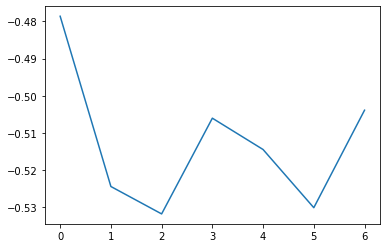

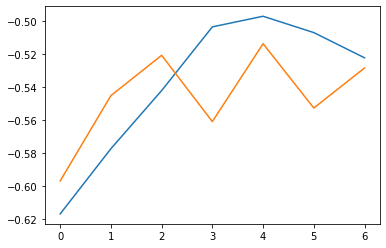

In [68]:
i = 11
plt.plot(val_y[i])
plt.plot(multioutputregressor.predict(val_X)[i])

In [44]:
np.mean((multioutputregressor.predict(val_X) - val_y)**2)

0.022419237

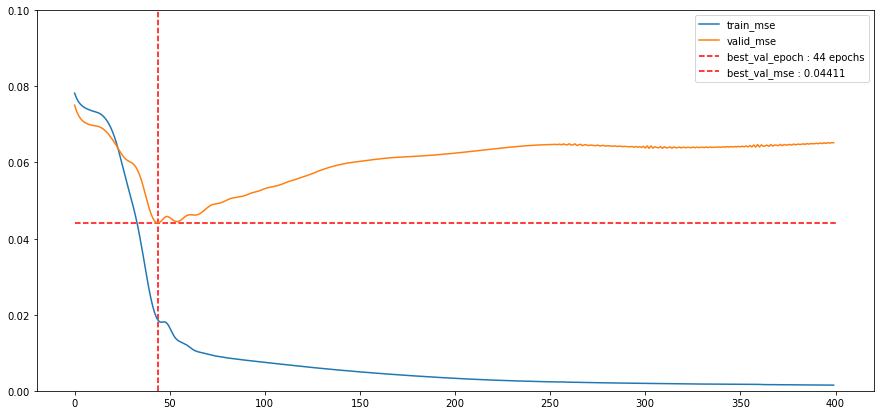

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

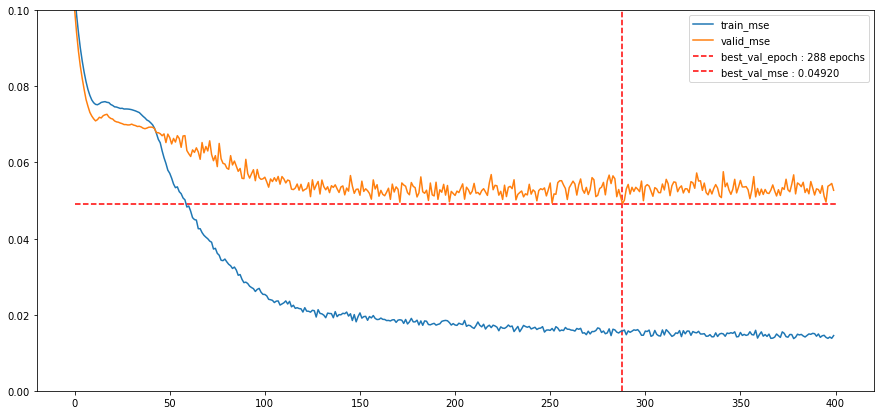

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# 마지막에 1개의 fc layer 추가

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

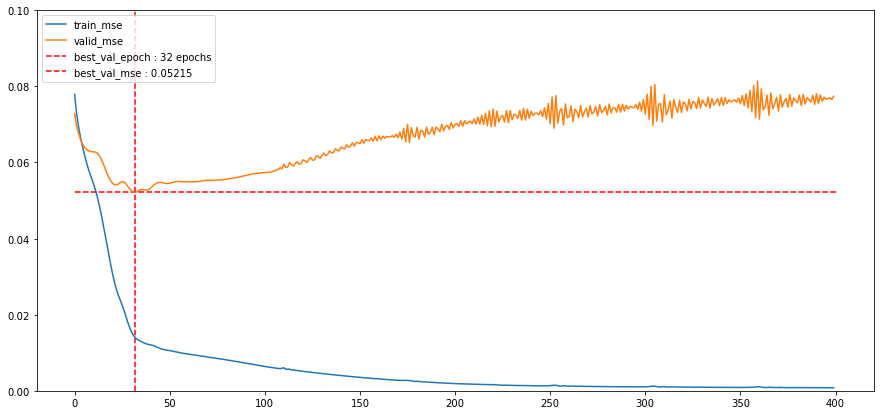

In [7]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# trend에서 사용했던 단순한 모델로 피팅
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

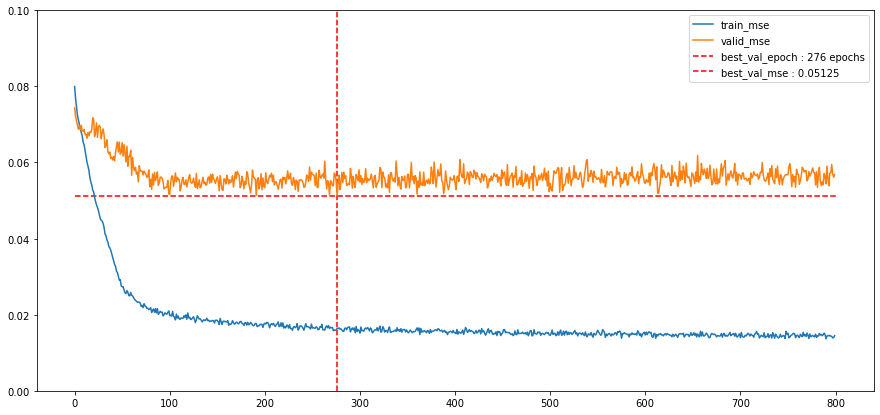

In [7]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# LSTM없이 가장 단순한 fc모델 사용
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

In [ ]:
# 출력을 전부 0으로 예측 했을 때.
valid_pred = model(valid_time, valid_notime)
valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
valid_mse# 0.06995933502912521

# 출력을 직전 주의 유동인구로 예측 했을 때.
valid_pred = model(valid_time, valid_notime)
valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
valid_mse# 0.07935082167387009


# 출력을 전부 평균이 0 표주편차가 1인 정규분포를 따르는 난수로 예측 했을 때.
valid_pred = model(valid_time, valid_notime)
valid_mse = float(criterion(valid_pred.cpu(), valid_y[:,:,1].cpu()))
valid_mse # 1.0973682403564453

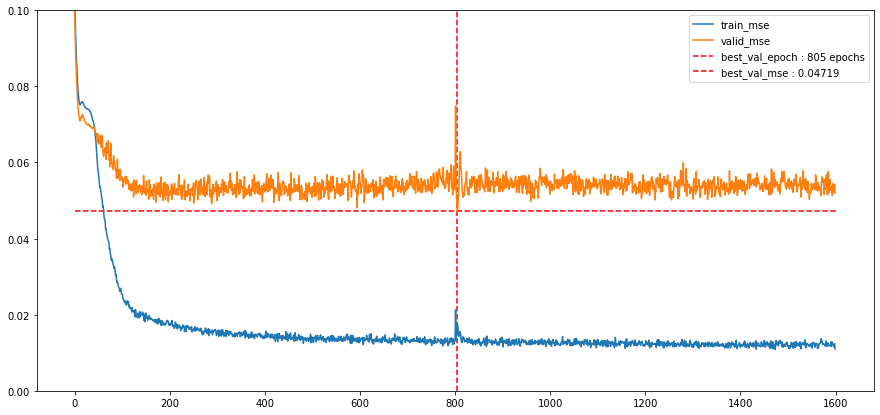

In [6]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm, 7일 단위로 나누어서 각자 7일치를 만든 후 fc로 결합
# 마지막 fc층 축소

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

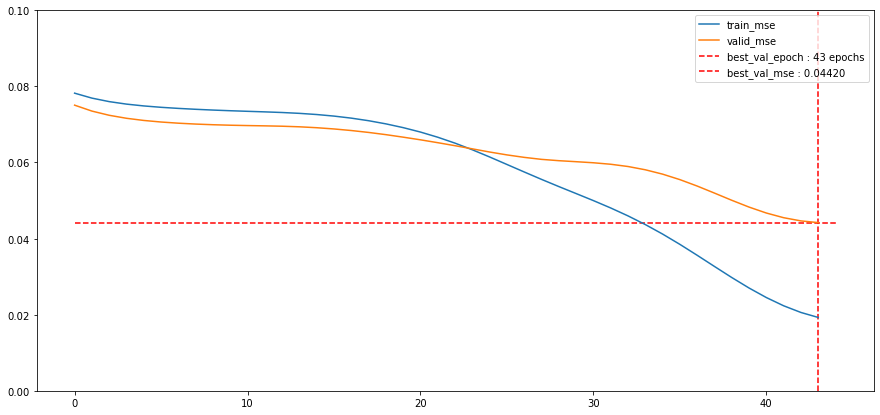

In [6]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm, 7일 단위로 나누어서 각자 7일치를 만든 후 fc로 결합
# 마지막 fc층 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

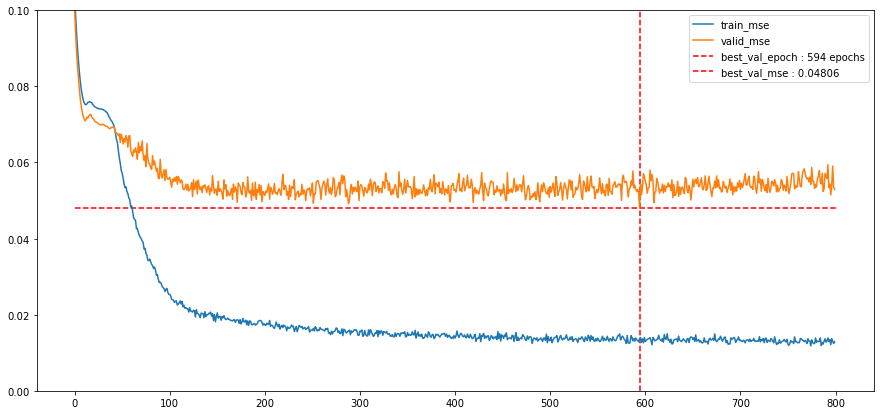

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm, 7일 단위로 나누어서 각자 7일치를 만든 후 fc로 결합

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

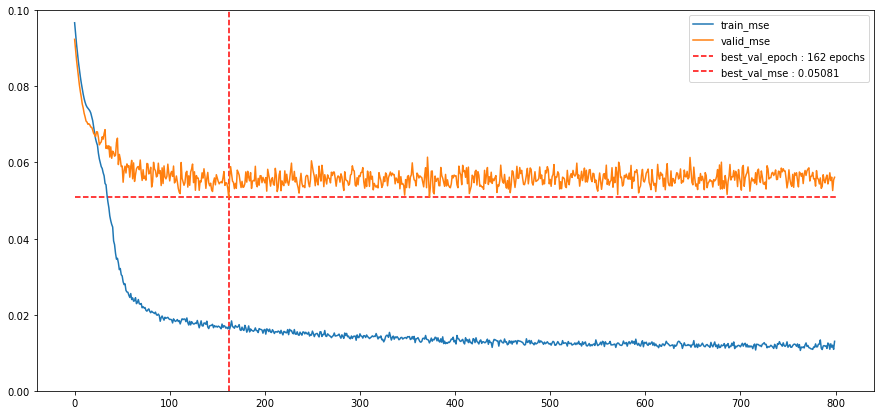

In [9]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm layer GRU layer 앙상블

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

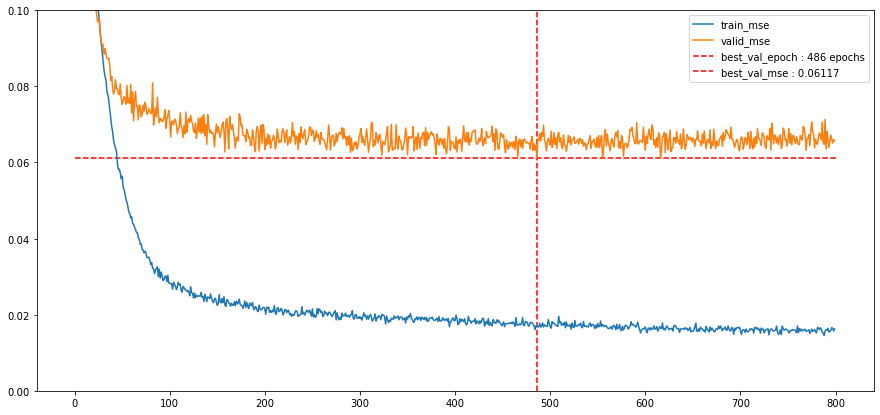

In [5]:
# cycle을 추출할 때 roll size =7 이동평균
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm layer GRU layer 앙상블


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

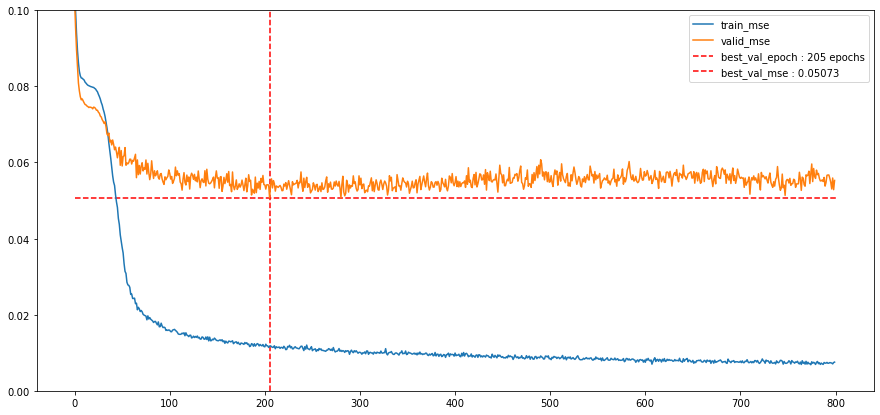

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm layer GRU layer 앙상블


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

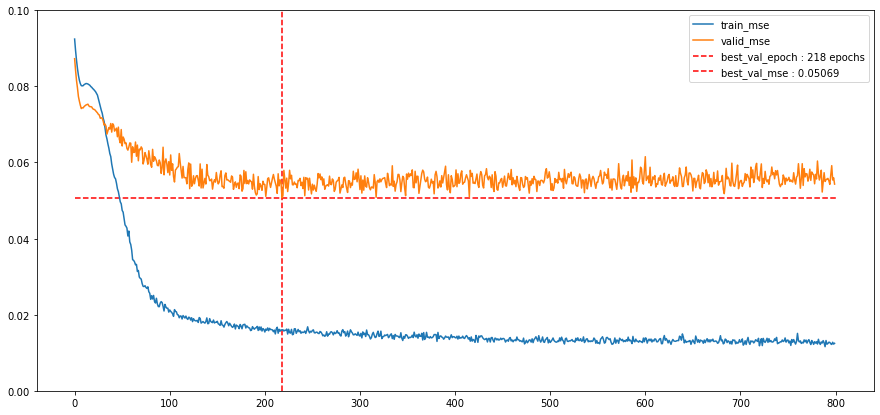

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# gru layer


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

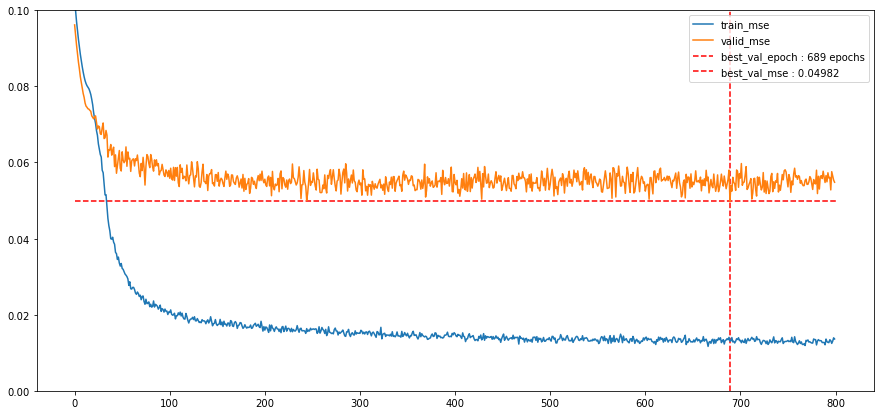

In [8]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm layer


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

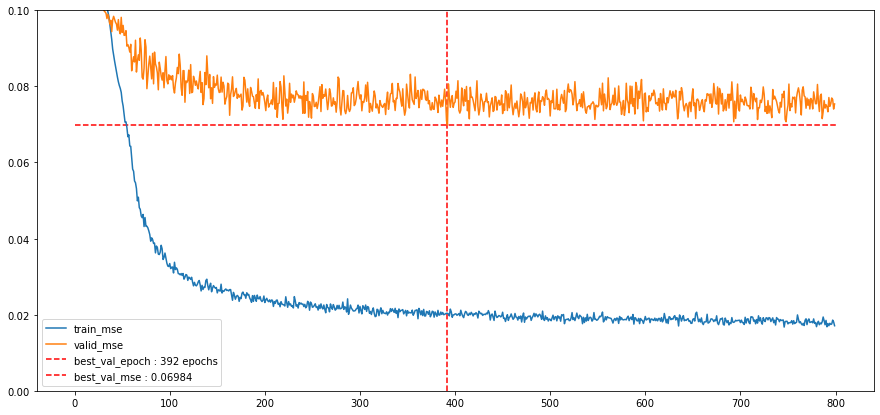

In [7]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# gru layer


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

In [ ]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# gru layer 1개


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

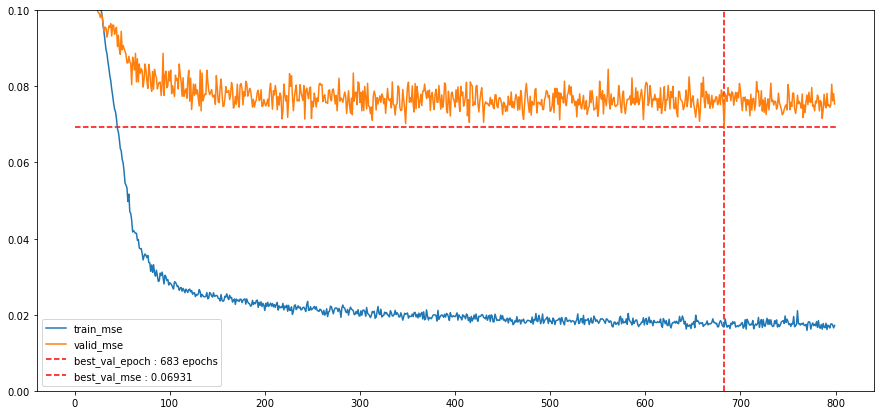

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# gru layer 1개


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

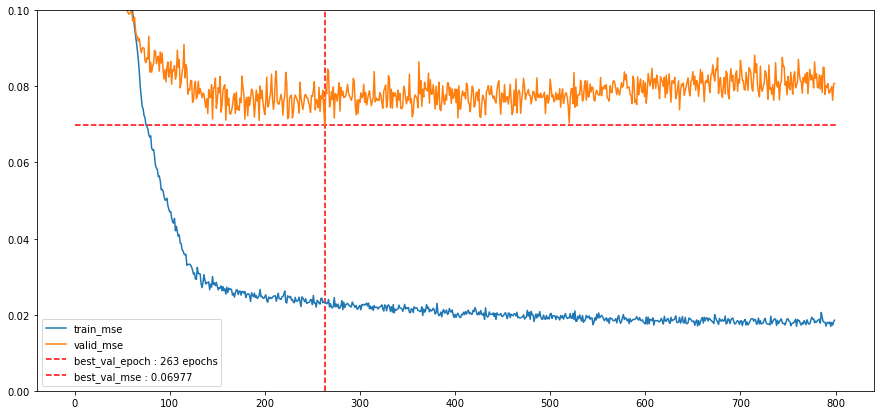

In [9]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm layer 2개, 중간에 dropout


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

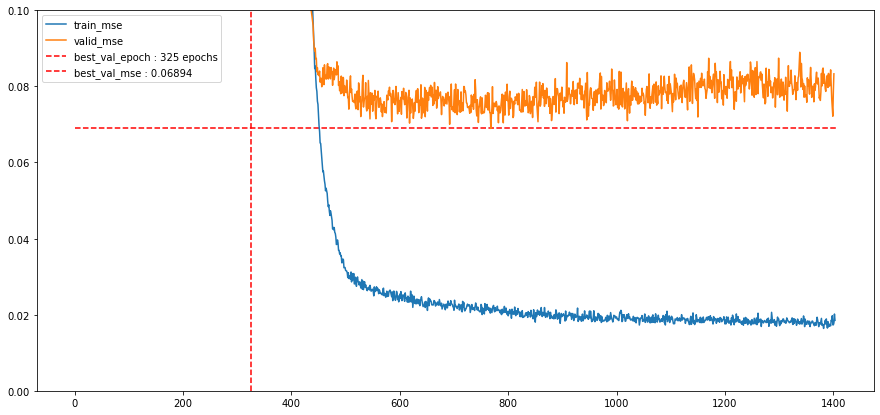

In [6]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm layer 추가


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

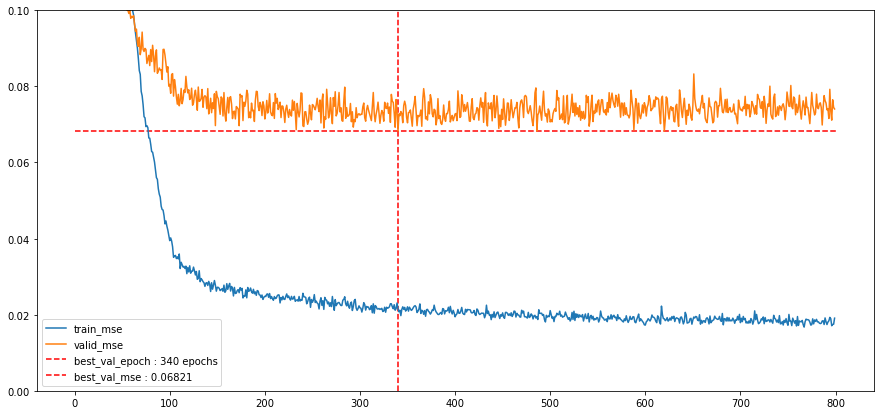

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가
# lstm layer 추가


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

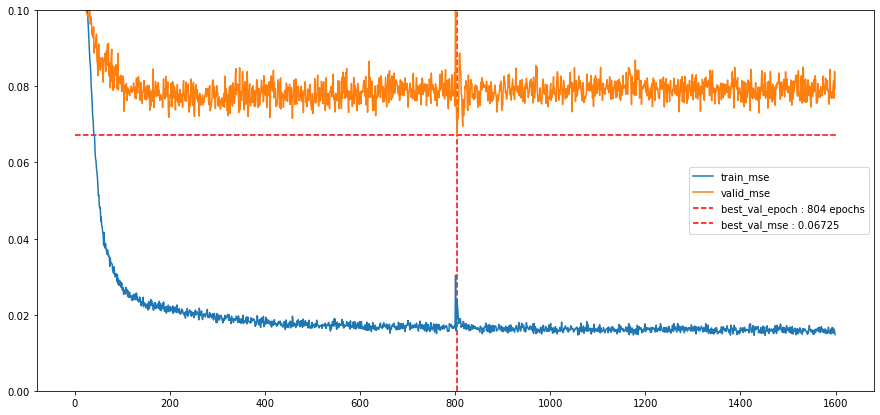

In [8]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용
# cycle size non time data로 추가


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

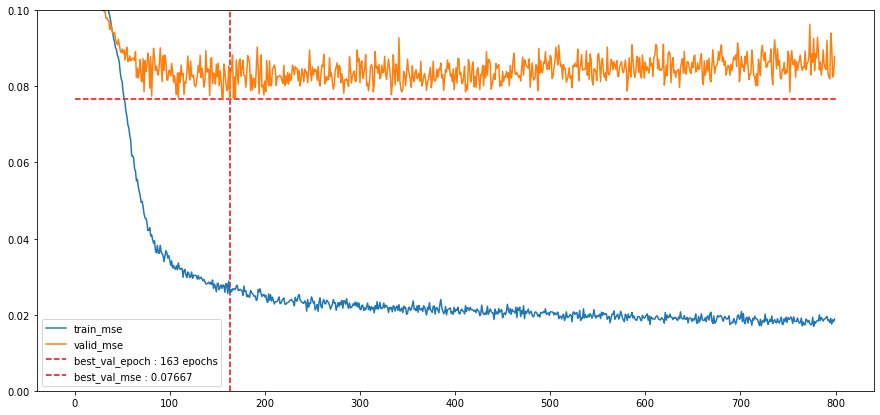

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# 모든 지역을 train에 사용


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

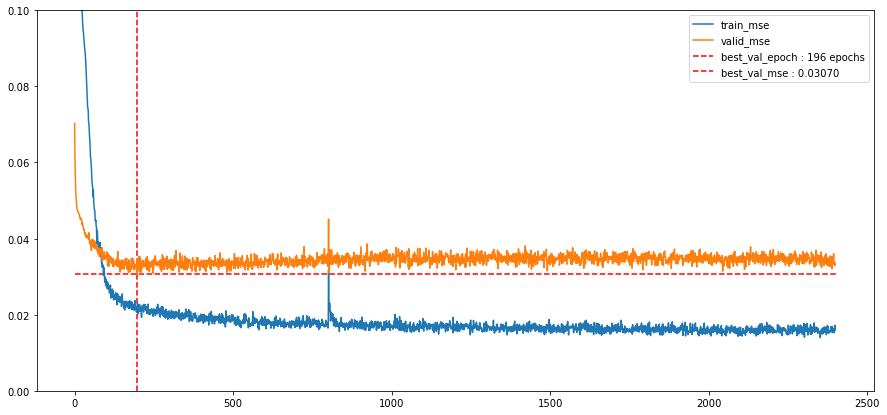

In [7]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

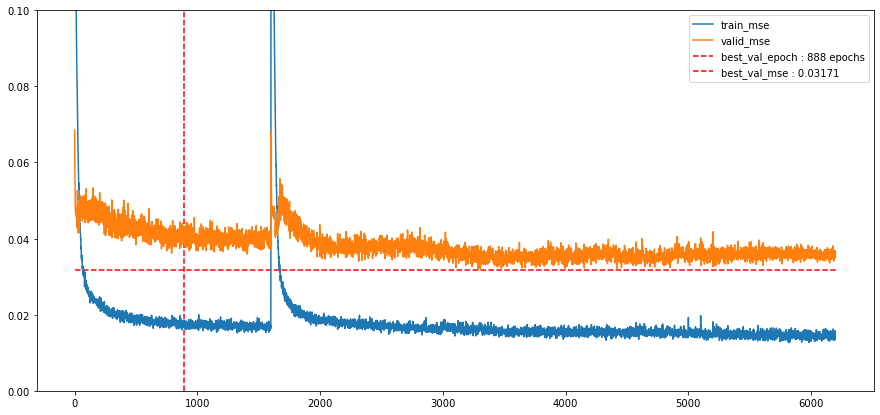

In [28]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# wighted rolling사용, 마지막 부분만 수정하는 모델

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

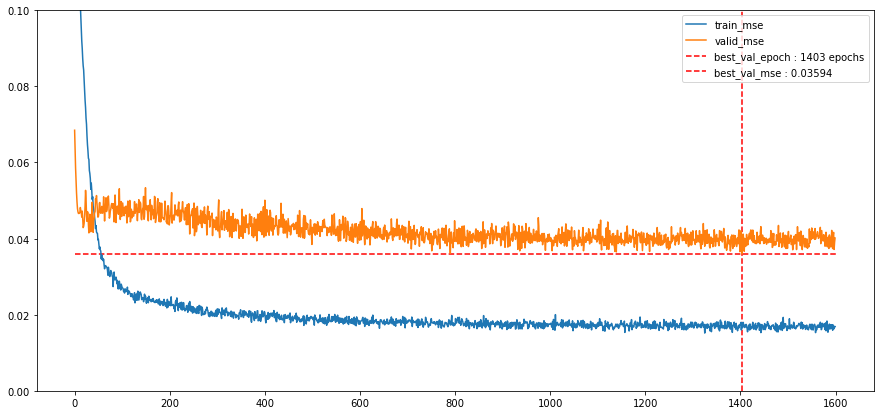

In [6]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# wighted rolling사용, 마지막 부분만 수정하는 모델

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

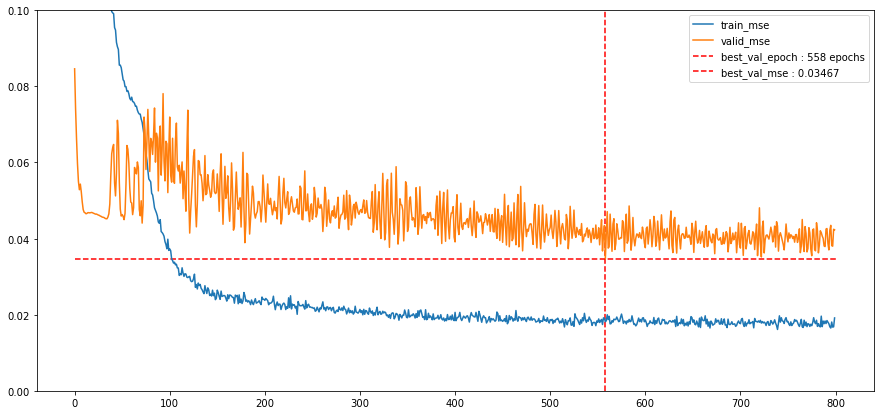

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# wighted rolling사용, 마지막 부분만 수정하는 모델
# 규제항 추가, lstm 2개층
# no time에 마시막 trend정보 추가

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

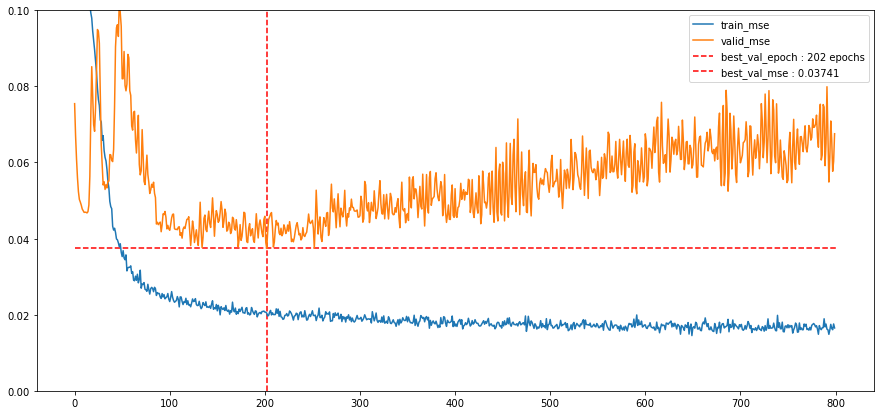

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# lstm층을 쌓고 (2개) dropout추가 -> 그닥
# wighted rolling사용, 마지막 부분만 수정하는 모델
# no time에 마시막 trend정보 추가

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

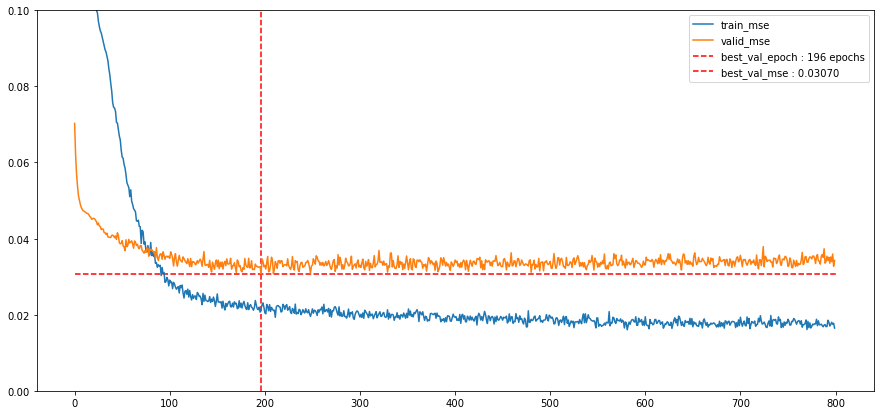

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# lstm층을 쌓고 (2개) dropout추가 -> 그닥
# wighted rolling사용, 마지막 부분만 수정하는 모델

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

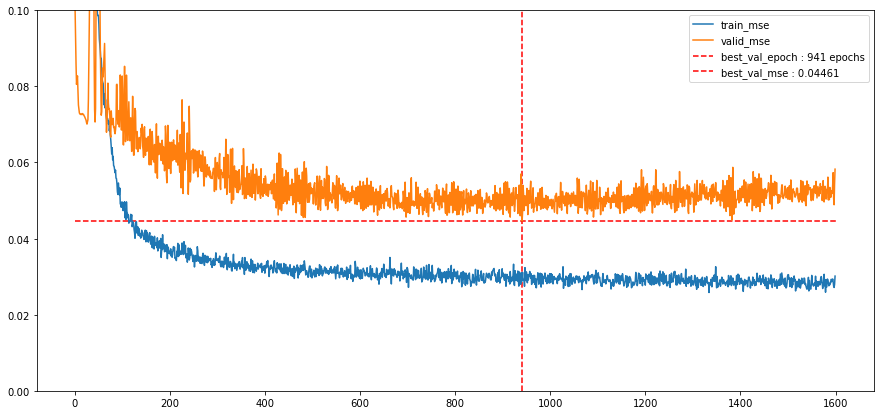

In [6]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# lstm층을 쌓고 (2개) dropout추가 -> 그닥

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

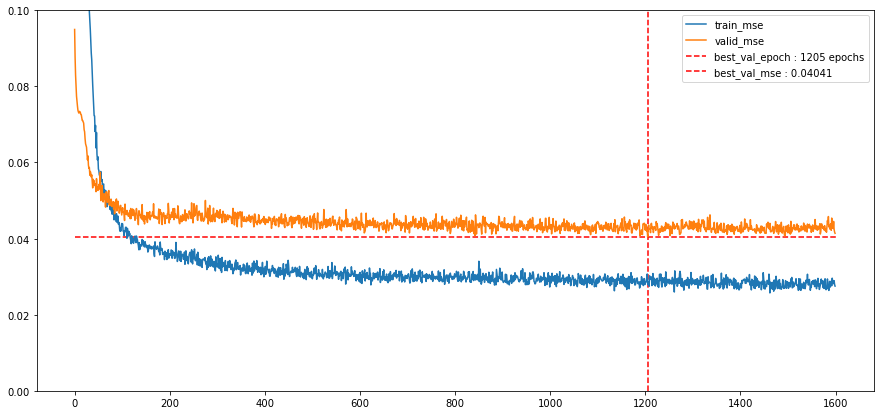

In [8]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가 가장 성능 좋음

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

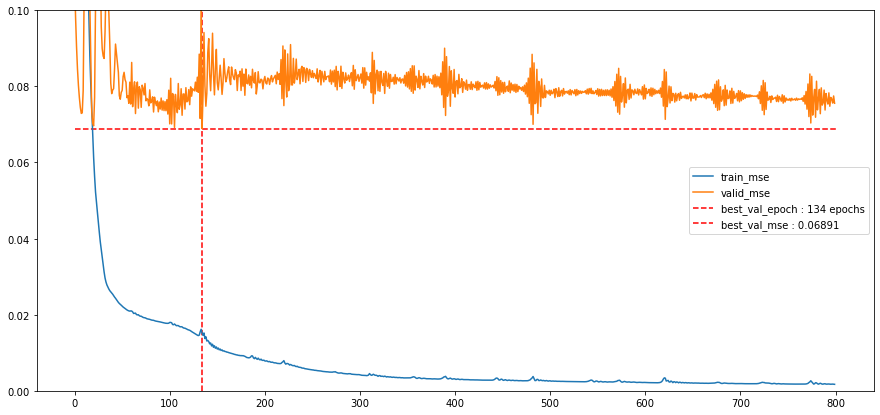

In [8]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# time fc층을 추가했더니 성능이 떨어짐

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

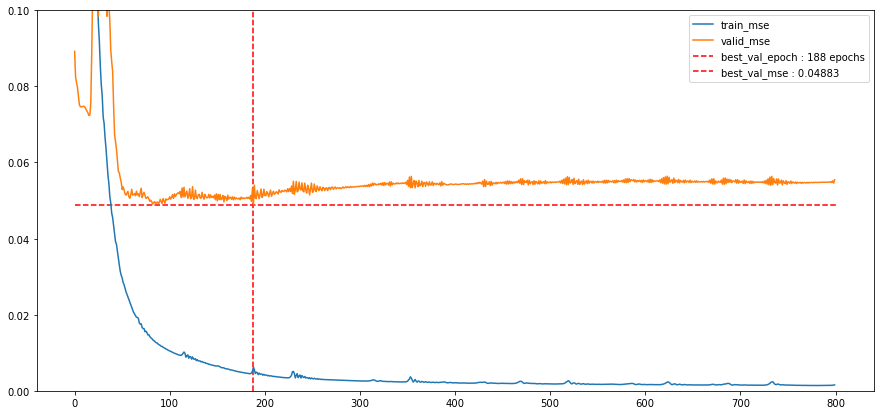

In [9]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# notime에 dropout추가
# 가장 최저 오차는 올랐지만 학습이 좀더 안정적

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

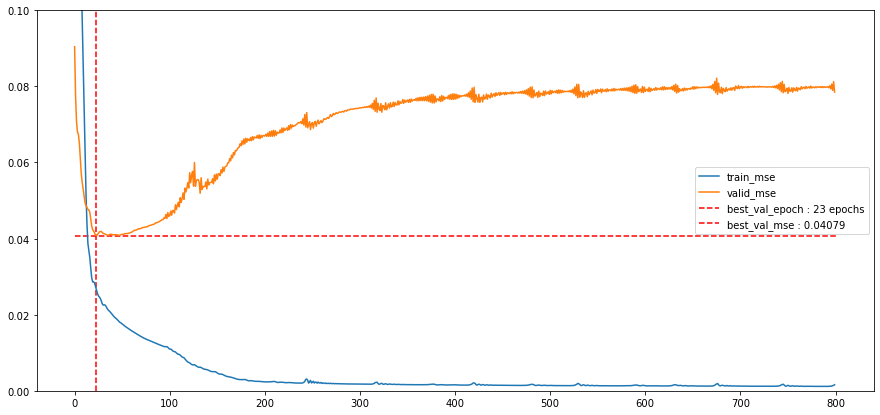

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data만 사용
# hiddensize = 32
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

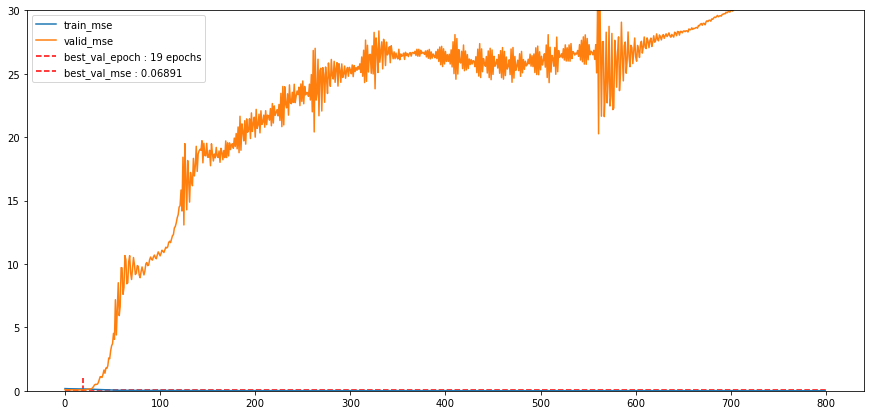

In [8]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# 요일정보 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,30)
plt.show()

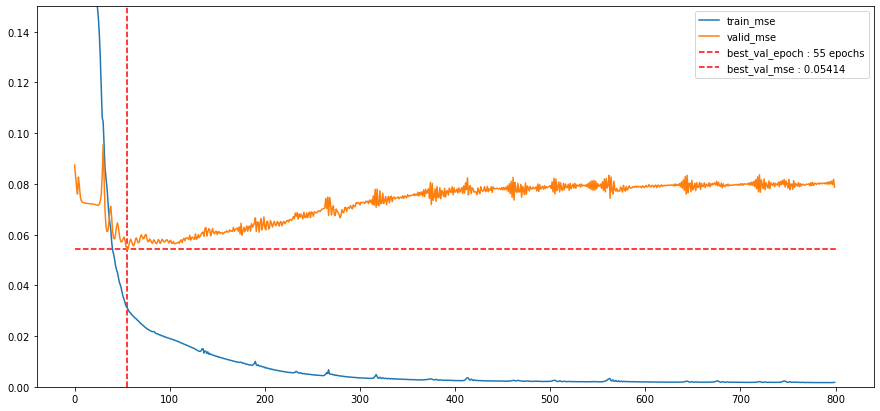

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# dayofyear만 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.15)
plt.show()

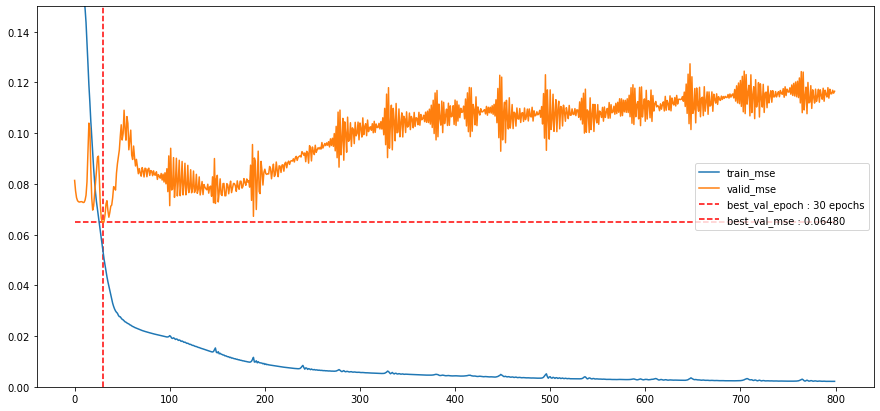

In [6]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# 공휴일만 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.15)
plt.show()

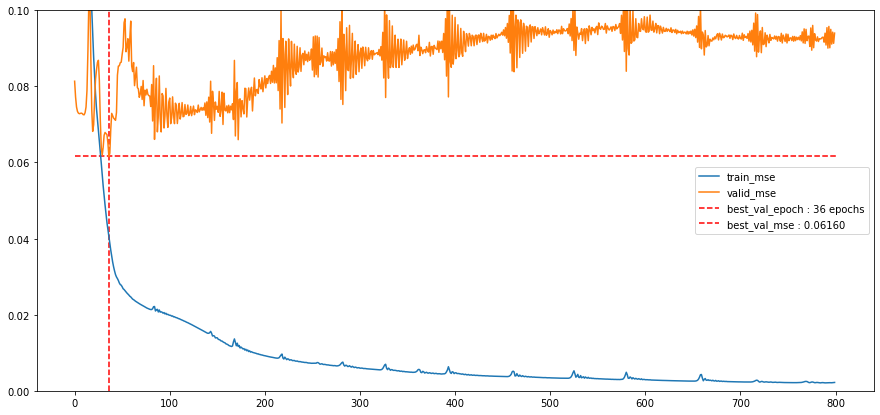

In [7]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# 코로나만 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

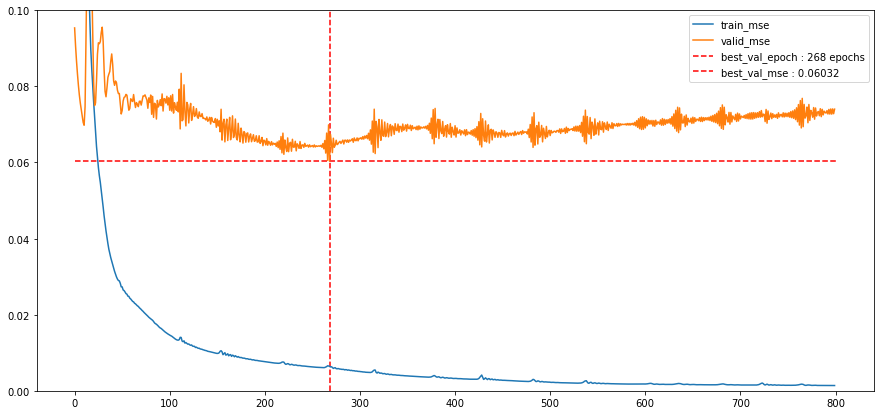

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32

# 온도, 섭도, 강수량 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

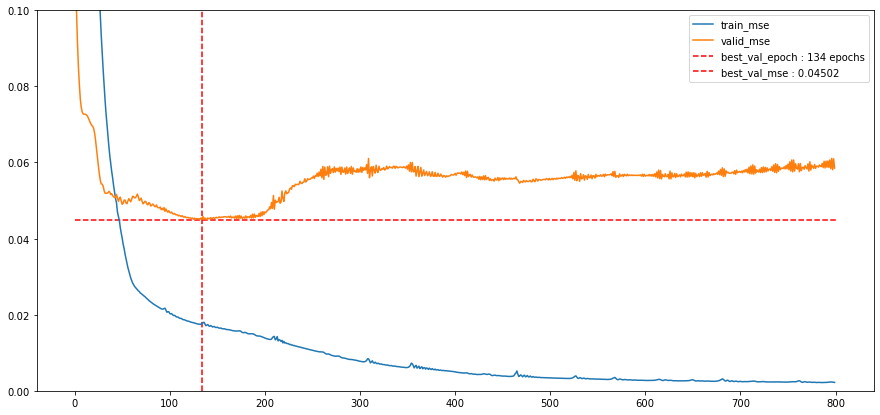

In [6]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

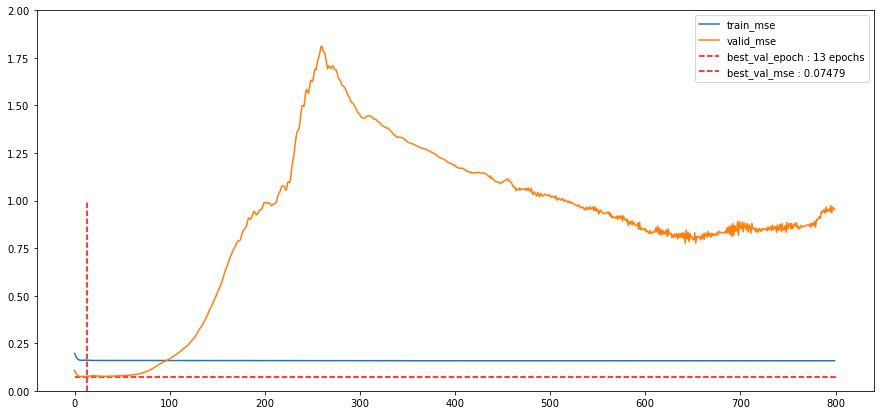

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 fc
# hiddensize = 32

# 초 오버피팅

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,2)
plt.show()

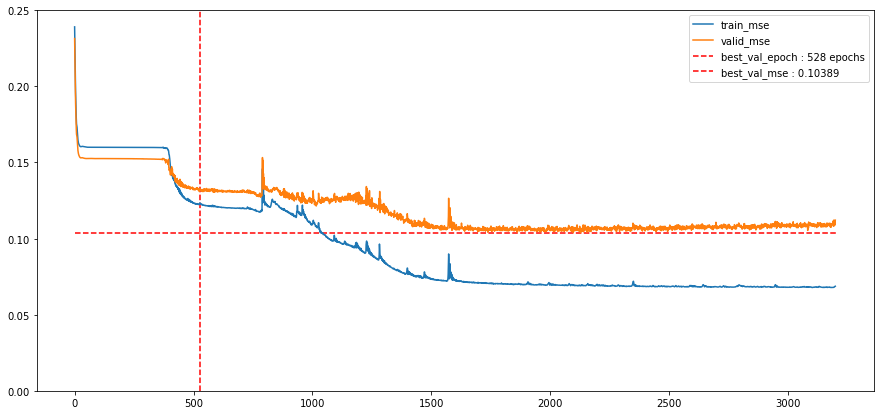

In [9]:
# cycle을 추출할 때 rolling을 21로 사용
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  seq2seq모델을 사용
# hiddensize = 32
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

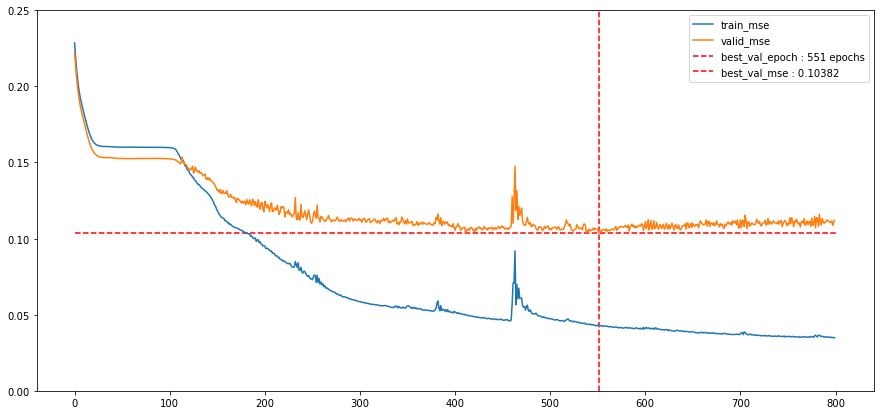

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
# hiddensize = 16
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

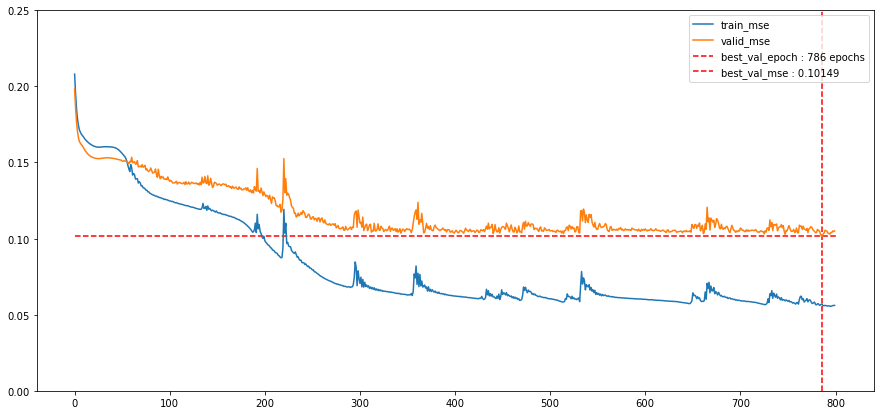

In [5]:
# cycle을 추출할 때 rolling을 21로 사용

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

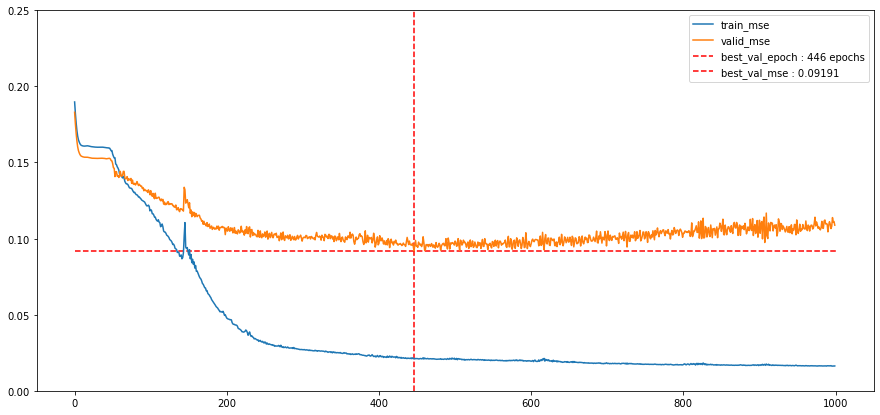

In [6]:
# cycle을 추출할 때 rolling을 21로 사용

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 1000,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

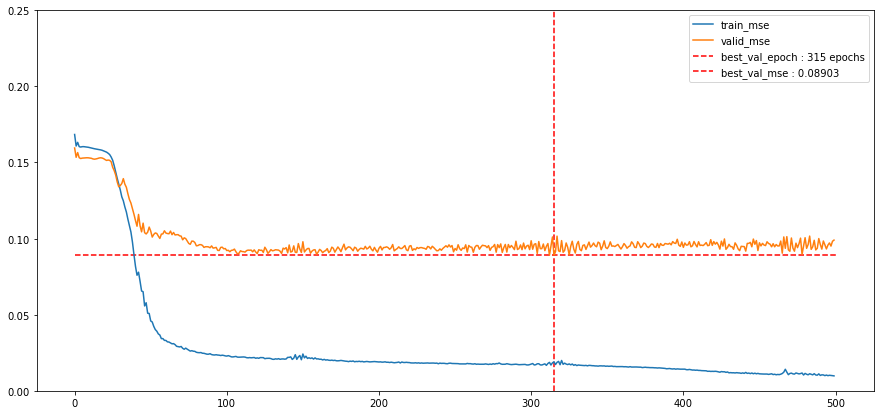

In [11]:
# cycle을 추출할 때 rolling을 21로 사용

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

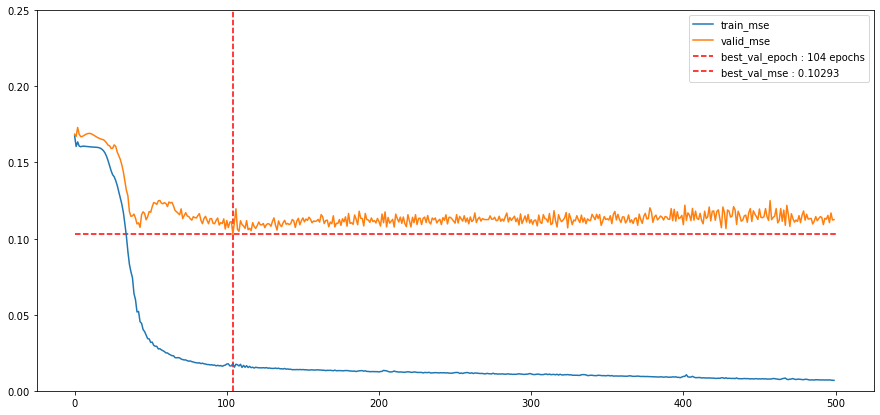

In [7]:
#ROLLING = 7

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

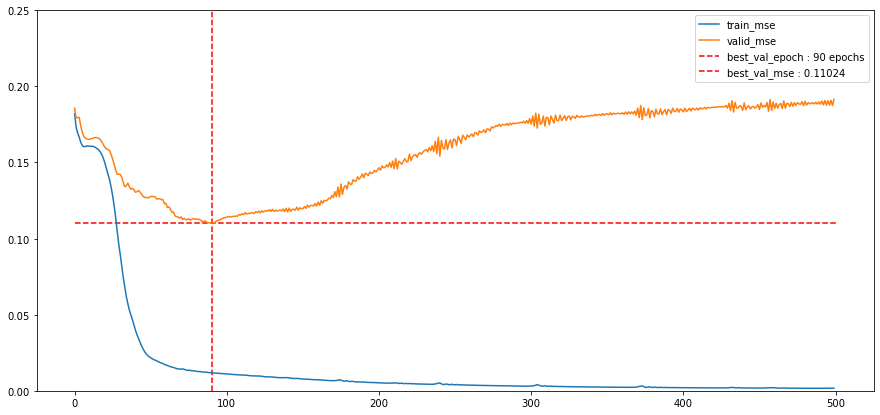

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# time을 lstm에 넣기 전에 notime을 곱해줌
# lstm 층 2개 통과
# 마지막 notime 을 3->3->3->1로
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

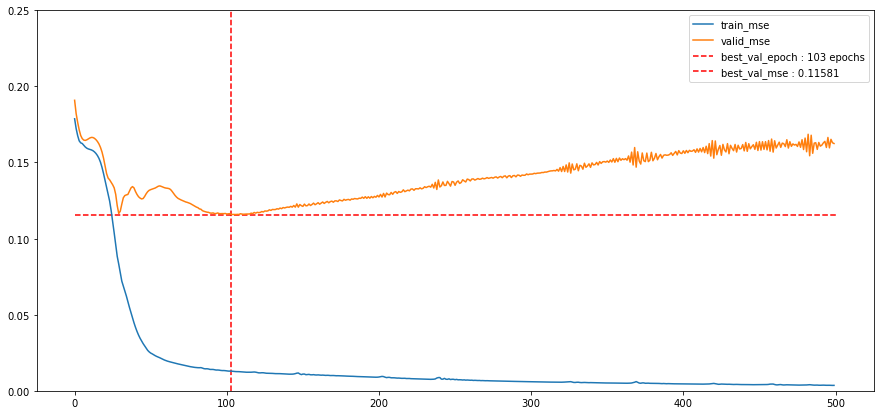

In [6]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# time을 lstm에 넣기 전에 notime을 곱해줌
# 마지막 notime 을 3->3->3->1로
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

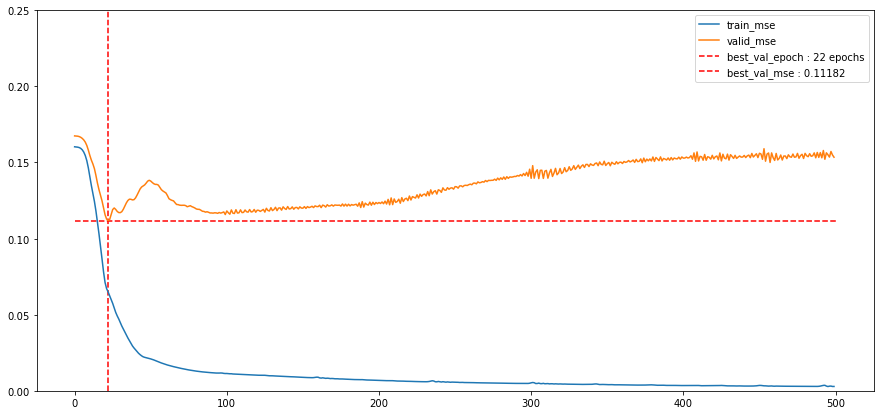

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# 마지막 output 을 32 -> 7
# 마지막 notime 을 3->3->3->1로
# 7개의 output에 notime을 곱

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

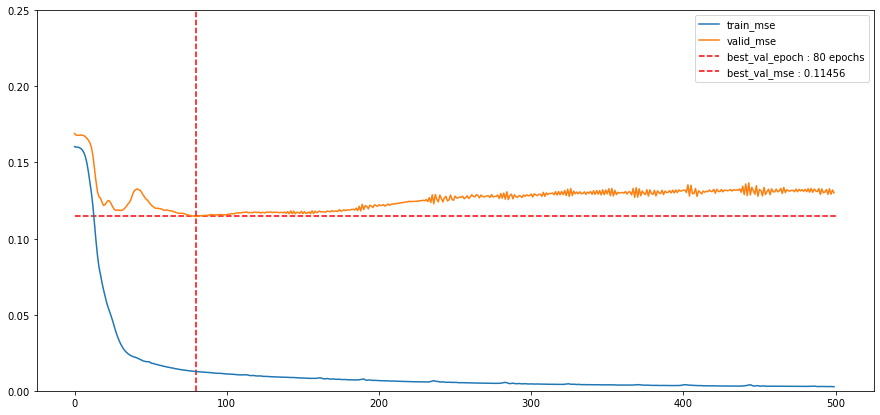

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# 마지막 output 을 32 -> 7
# 마지막 notime 을 3 ->32->16->8->4 1로

# 7개의 output에 notime을 곱


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

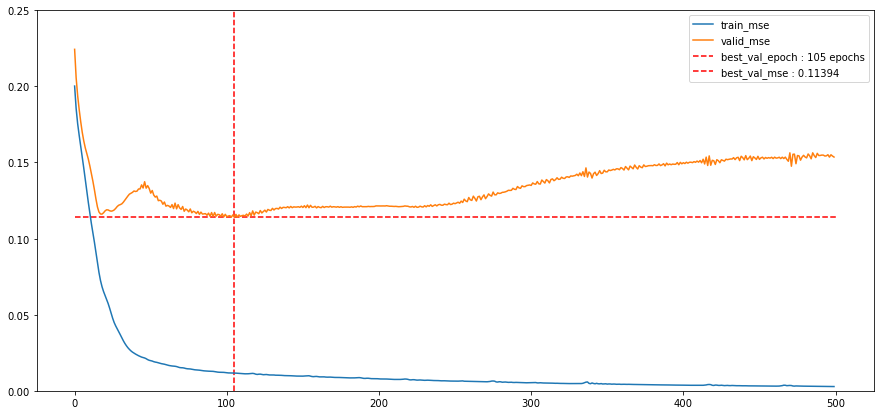

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data만 사용한 모델
# 마지막 output 을 32 -> 7 nn하여 출력

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

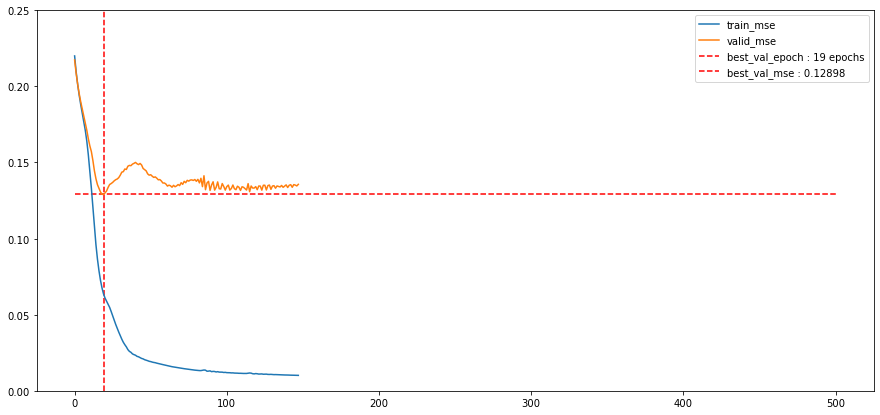

In [26]:
# train 모든 데이터로 scaler학습
#  기본 모델


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

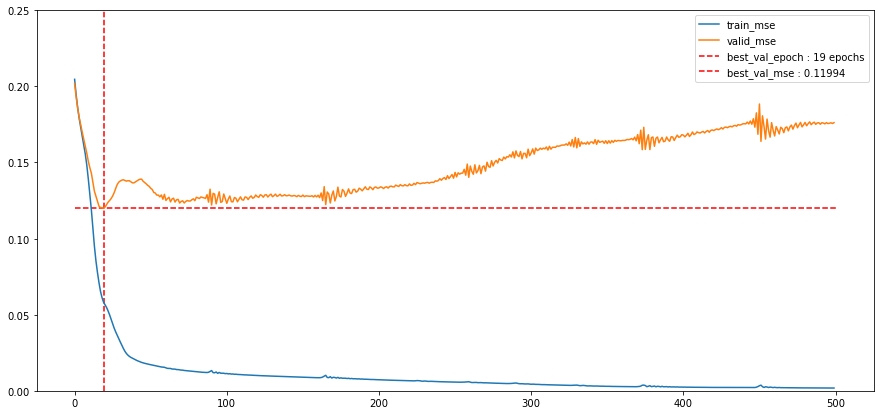

In [9]:
#  train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
#  기본 모델


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

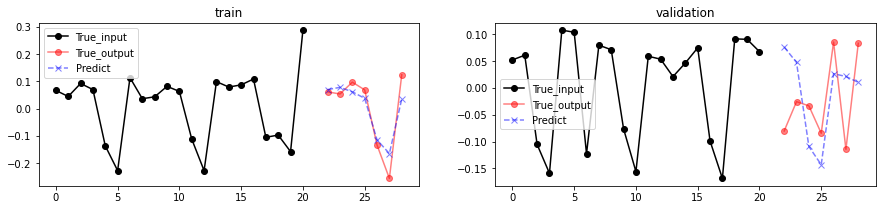

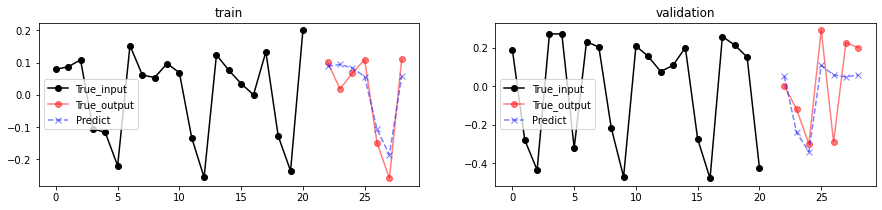

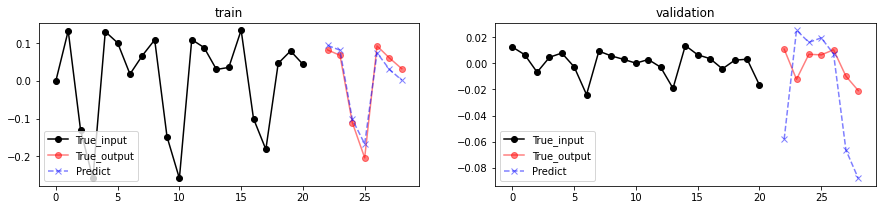

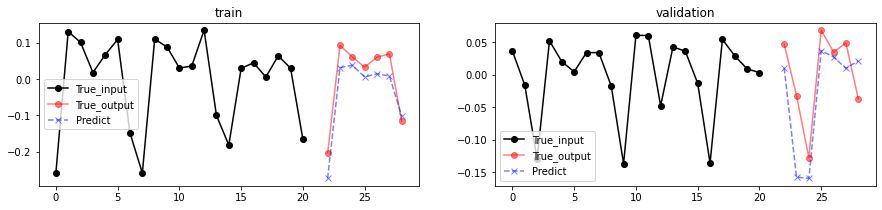

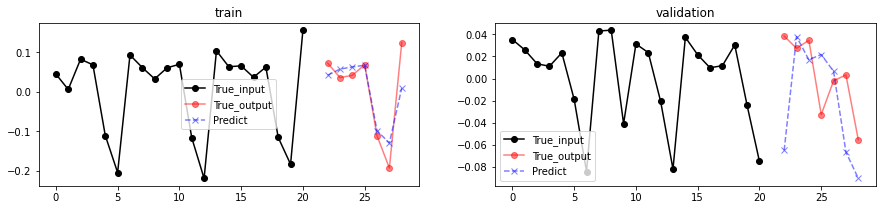

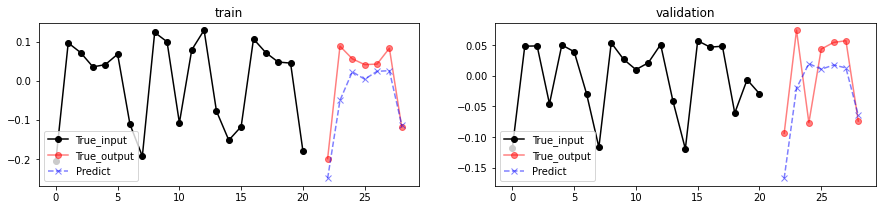

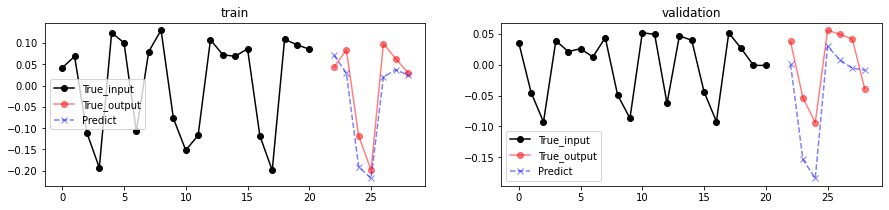

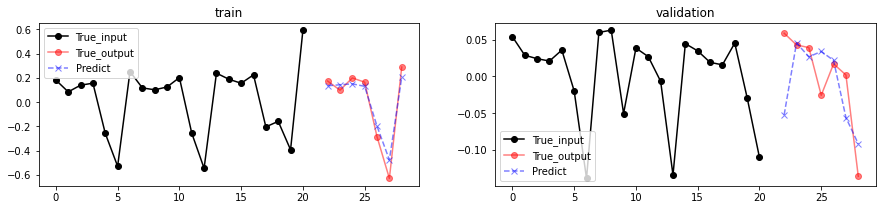

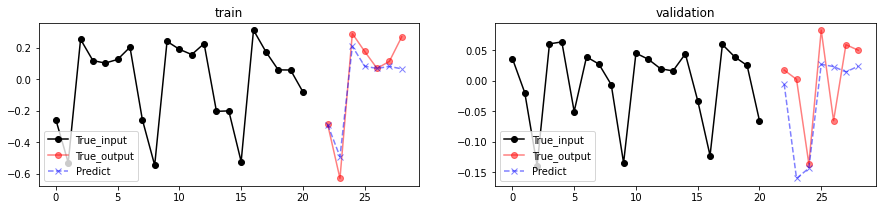

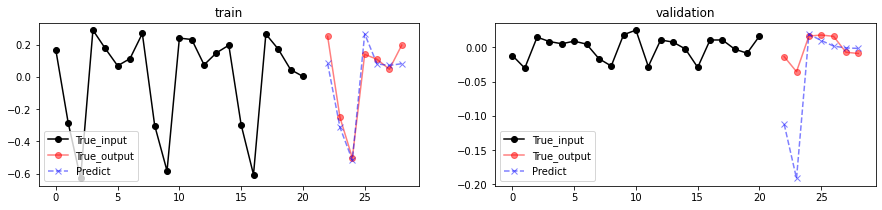

In [7]:
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = '../data/train_results/morning_results/'
with open(path + 'm_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

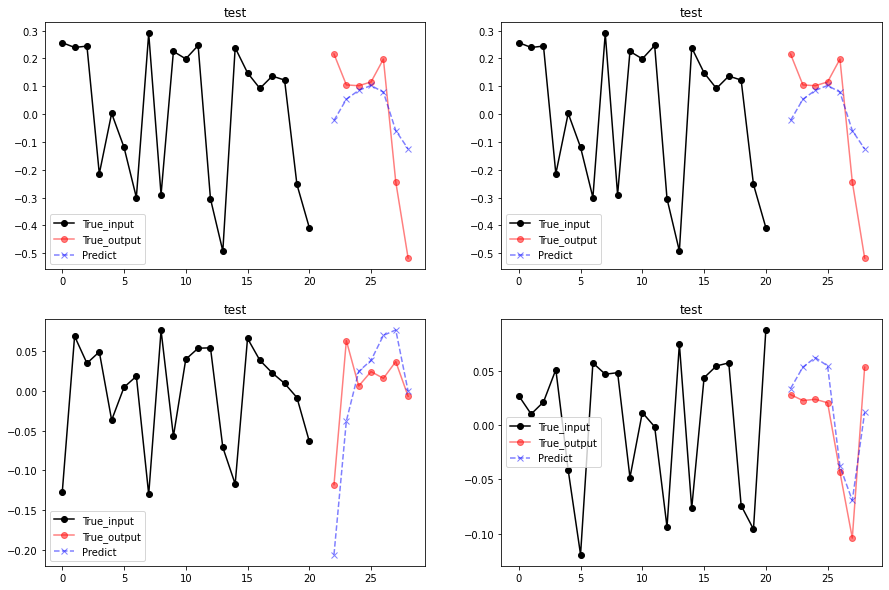

In [8]:
train_pred = best_model(train_time, train_notime)
test_pred = best_model(test_time, test_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        test_time[:,:,-1], test_y[:,:,1], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    test_time_x_np, test_y_np, test_pred_np]

In [19]:
def plot_test_predict(train_x, train_y, train_pred):
    plt.figure(figsize = (15, 10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        i = random.randint(1,21) + i*11
        plt.plot(np.arange(21), train_x[i,:],   # m_train_time.cpu().detach().numpy()[i,:,-2],
                marker = 'o', color = 'black', label = 'True_input')
        plt.plot(np.arange(22,29), train_y[i],    #m_train_y[:,:,0].cpu().detach().numpy()[i],
                marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
        plt.plot(np.arange(22,29),train_pred[i],    #.cpu().detach().numpy()[i],
                color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
        plt.title('test')
        plt.legend()
    plt.show()
